### Расположение файлов
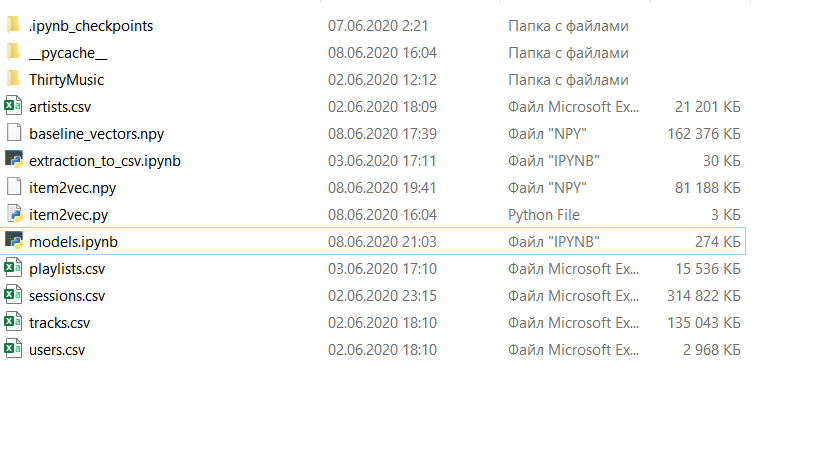

**Протокол оценки качества**
---

> **Метрика**

Так как основная задача - векторизовать музыкальных исполнителей так, чтобы *похожие* музыкальные исполнители оказались ближе к другу в векторном пространстве, чем *непохожие*, необходимо определиться с тем, как мы определяем похожесть двух исполнителей. Это можно сделать с помощью множества естественных метрик или их комбинаций, например: 

*   процент пересечения аудитории,
*   жанровая схожесть,
*   возраст исполнителя,
*   и пр.

Но так как данные векторные представления нужны для решения задачи **Artist Recommendation**, я считаю, что сравнивать *похожесть* двух исполнителей, нужно с точки зрения этой задачи, например с помощью косинусного расстояния между вектором порекомендованого артиста и вектором выбранного, или бинарно - угадан артист или нет.

---

Поскольку у нас нет данных реальных рекомендаций и выборов пользователей, я предполагаю, что для моделирования выбора пользователем исполнителя **B** наиболее похожего к исполнителю **A** можно использовать пользовательские плейлисты и сессии* прослушивания, предполагая, что в них представлена неслучайная последовательность треков.

---


> **Валидация**

Валидировать построенные векторные представления я буду на плейлистах и сессиях, убрав повторы исполнителей из этих последовательностей, следующим образом: берем ближайший вектор исполнителя к исполнителю **n** и проверяя верно ли предсказан исполнитель **n+1** или нет. Результат - Accuracy по плейлисту.

*Здесь можно было бы использовать более сложные подходы или ML/DL алгоритмы, с помощью которых мы предсказывали бы исполнителя, но т.к. основной задачей является построение векторных представлений, и в задании описано, что рекомендация в идеале должна сводиться к knn, я считаю, что в этом нет необходимости*



> **Проверка статистической значимости**

Полученные значения (список значений Accuracy по плейлистам) получены на одной и той же тестовой выборке, и распределение этих значений не нормально. Для проверки стат. значимости разности результатов можели я буду использовать односторнний критерий Вилкоксона. 


---


*но это не точно



















***Модели***
---


> Бейзлайн

Берем векторное пространство размера n, где n это количество артистов. Базисом в этом векторном пространстве рассмотрим набор артистов, которые сделаны из данных n артистов, путем удаления пересечений между артистами, кроме пересечений самих с собой. После этого строим матрицу Количество исполнителей х Количество исполнителей, где на пересечении исполнителей записано отношение количества их общей аудитории к минимуму из количеств слушателей этих артистов. При таком разложении разносортные артисты у нас *перпендикулярны* -> скалярное произведение равно 0.

 **r(x,y) = (|x U y| / min(|x|, |y|)).**


Для каждого артиста мы получим разложение по базису этого пространства. Таким образом мы можем использовать скалярное произведение для подсчета косинусного расстояния между векторами.
 
 **Проблемы**

Нормировка каждого элемента такой матрицы занимает огромное количество времени на моем комппьютере, и чтобы сохранить свойство разложения по базису, я нормирую xi,j на количество слушателей артиста i. Чтобы потом можно было использовать эти вектора, мне приходится понижать их размерность.

> **Идея 1. Матричные разложения**

Естественной кажется идея применить стандартные подходы к построению рекомендаций, такие как SVD / ALS разложения. У нас есть история прослушиваний пользователей и их оценки трекам ("love"). Если смапить треки в их авторов, мы можем сделать матрицу Исполнитель-Пользователь, а затем приблизить ее каким-нибудь разложением. А затем из получившегося разложения взять матрицу Исполнителей, с соотвествующими им векторами.

**Проблемы**

1.   Даже sparse матрица Количество пользователей х Количество исполнителей не влезает в память :(
2.   Медленно :(


> **Идея 2. Эмбединги**

Рядом с вышеизложенным способом валидации сразу напрашивается моделька, которая бы предсказывала Исполнителей по контексту (Плейлисту). + было бы здорово, если бы она учитывала, а как часто какие Исполнители встречаются друг с другом, т.е. еще и имела бы какие-то черты SVD - давайте возьмем за основу GloVe!

**Проблемы** 
1.  Большая sparse матрица Количество исполнителей х Количество исполнителей
2.  Медленно

Решение1 - использовать GPU (например реализацию на торче), но тогда возникает та же проблема с sparse матрицей. Быстро решить эту проблему и завести GloVe у меня не удалось :(

Решение2 - использовать word2vec, т.е. в нашем случае cbow и negative sampling для artist2vec задачи.





In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# root = '/content/drive/My Drive/'

In [2]:
# if running locally
root = ''

In [119]:
import pandas as pd
import numpy as np
import random

import umap

import ast
import urllib
from collections import Counter

import os
import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

from scipy.sparse import lil_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer

import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook

import item2vec
import torch
torch.cuda.current_device()
import torch.nn as nn
import torch.optim as optim

import scipy.stats as st

In [4]:
EMBEDDING_DIM = 150

1. Считываем треки для мапинга **трек -> автор(ы)**

In [78]:
tracks = pd.read_csv(root+'tracks.csv')
track_to_author = dict(zip(tracks.ID.values, tracks.author_id.values))
del tracks

D:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [79]:
playlists = pd.read_csv(root+'playlists.csv')
sessions = pd.read_csv(root+'sessions.csv')
playlists.tracks_ids = playlists.tracks_ids.apply(lambda x: ast.literal_eval(x))
sessions.tracks = sessions.tracks.apply(lambda x: ast.literal_eval(x))

In [80]:
def convert_to_unicode(text):
    if '%' in text:
        text = urllib.parse.unquote(text)
    return text.replace('+',' ')

artists = pd.read_csv(root+'artists.csv')
artists['name'] = artists['name'].apply(lambda x: convert_to_unicode(x))
artists = artists.drop_duplicates(subset=['ID'])
id_to_author = dict(zip(artists.ID.values, artists.name.values))
author_to_id = dict(zip(artists.name.values, artists.ID.values))

In [81]:
RANDOM_STATE = 40
TEST_SIZE = 4000
EXTRACTED_SESSIONS = 120000

In [82]:
sessions_sample = sessions.sample(EXTRACTED_SESSIONS, random_state = RANDOM_STATE)
test_playlists_idx = playlists.sample(TEST_SIZE, random_state = RANDOM_STATE).index.values
test_sessions_idx = sessions_sample.sample(TEST_SIZE, random_state = RANDOM_STATE).index.values

train_playlists = []
test_playlists = []

full_set = set()
train_set = set()
test_set = set()
users_set = set()
artists_counter = {}


def get_rid_of_unknown_auhtors(train_set, test_list):
    ids_to_pop = []
    test_set = set()
    for i, playlist in enumerate(test_list):
        kek = train_set
        kek.update(playlist)
        if len(train_set) != len(kek):
            ids_to_pop.append(i)
            continue
        test_set.update(playlist)
    for i in ids_to_pop:
        test_list.pop(i)
    return test_list, test_set


def extract_train_test(data, tracks_str, test_id, 
                       test_set=test_set, train_set=train_set, full_set=full_set,
                      train_playlists=train_playlists, test_playlists=test_playlists, users_set=users_set):
    
    for playlist, index, user_id in zip(data[tracks_str].values, data.index.values, data.user_id.values):
        users_set.add(user_id)
        artists_playlist = []
        for song in playlist:
            for authors in ast.literal_eval(track_to_author[song]):
                artists_playlist.append(authors)
                if artists_counter.get(authors):
                    artists_counter[authors] += 1
                else:
                    artists_counter[authors] = 1
        if index in test_id:
            test_playlists.append(artists_playlist)
            test_set.update(artists_playlist)
        else:
            train_playlists.append(artists_playlist)
            train_set.update(artists_playlist)
    return train_set, test_set, train_playlists, test_playlists, users_set 

In [83]:
train_set, test_set, train_playlists, test_playlists, users_set = extract_train_test(playlists, 'tracks_ids', test_playlists_idx)
train_set, test_set, train_playlists, test_playlists, users_set = extract_train_test(sessions_sample, 'tracks', test_sessions_idx)

In [84]:
test_playlists, test_set = get_rid_of_unknown_auhtors(train_set, test_playlists)

In [85]:
assert len(test_set) == len(test_set & train_set)

In [86]:
print('Всего артистов: ', len(set(author_to_id.values())))
print('Артистов в извлеченных плейлистах и сессиях: ',len((train_set|test_set) & set(author_to_id.values())))

Всего артистов:  560927
Артистов в извлеченных плейлистах и сессиях:  138560


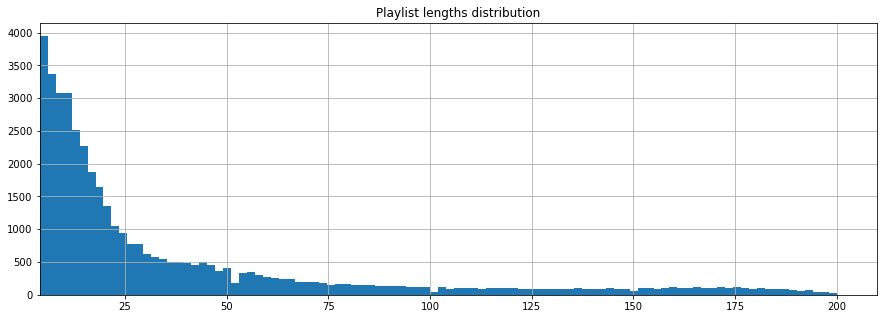

In [87]:
plt.figure(figsize=(15, 5))
playlists.numtracks.hist(bins=100)
plt.title('Playlist lengths distribution')
plt.xlim(left=4)
plt.show()

In [88]:
print('Средняя длина сессии: ', sessions.numtracks.mean())
print('Мода длины сессии: ', sessions.numtracks.mode()[0])
print('Максимальная длина сессии: ', sessions.numtracks.max())
print()
print('Средняя длина плейлиста: ', playlists.numtracks.mean())
print('Мода длины плейлиста: ', playlists.numtracks.mode()[0])
print('Максимальная длина плейлиста: ', playlists.numtracks.max())

Средняя длина сессии:  17.071055122512117
Мода длины сессии:  4
Максимальная длина сессии:  4914

Средняя длина плейлиста:  38.2287082952193
Мода длины плейлиста:  4
Максимальная длина плейлиста:  200


In [89]:
# technical column
artists = artists[artists.ID.isin(test_set|train_set)]
artists['new_ID'] = [i for i in range(artists.shape[0])]

old_id_to_new_id = dict(zip(artists.ID.values, artists.new_ID.values))
id_to_author = dict(zip(artists.new_ID.values, artists.name.values))
author_to_id = dict(zip(artists.name.values, artists.new_ID.values))


for playlist in train_playlists:
    for i in range(len(playlist)):
        playlist[i] = old_id_to_new_id[playlist[i]]
        
for playlist in test_playlists:
    for i in range(len(playlist)):
        playlist[i] = old_id_to_new_id[playlist[i]]

#### Baseline vectors

In [113]:
if 'baseline_vectors.npy' in os.listdir():
    del playlists
    del sessions
    del artists 
    result_vecs = np.load('baseline_vectors.npy')

else:
    tracks_to_boa = pd.concat((sessions_sample[~sessions_sample.index.isin(test_sessions_idx)][['user_id', 'tracks']], playlists[~playlists.index.isin(test_playlists_idx)][['user_id', 'tracks_ids']].rename(columns={'tracks_ids' : 'tracks'}))).groupby('user_id').sum().tracks.values.tolist()

    # делаем bag of artists для каждого пользователя 
    for i, tracks in enumerate(tracks_to_boa):
        tracks_to_boa[i] = [old_id_to_new_id[id_] for id_ in list(set(sum([ast.literal_eval(track_to_author[song]) for song in tracks], [])))]

    del playlists
    del sessions
    del artists    

    boa = lil_matrix((len(users_set), len((train_set|test_set))), dtype=np.int8)
    for i, artists in enumerate(tracks_to_boa):
        for artist in artists:
            boa[i, artist] = 1

    # делаем матрицу совместной встречаемости артистов
    result_vecs = boa.T @ boa 

    del boa


    # получившиеся вектора очень большие, нормировка их компонент занимает очень много времени
    # также матрица предпосчитанных косинусных занимает очень много места, и выисляется долго

    # чтобы получить векторы поменьше которые влезли бы в память, понизим размерность
    svd = TruncatedSVD(n_components=EMBEDDING_DIM, n_iter=2)
    result_vecs = svd.fit_transform(result_vecs) / result_vecs.diagonal()

    np.save('baseline_vectors.npy', result_vecs)

#### Item2Vec

In [18]:
total_count = sum([len(play) for play in train_playlists])
artists_counter = {artists:count/total_count for artists, count in zip(artists_counter.keys(), artists_counter.values())}

In [19]:
def get_target(words, idx, window_size=5):    
    R = np.random.randint(1, window_size+1)
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    target_words = words[start:idx] + words[idx+1:stop+1]
    return list(target_words)

In [20]:
def get_batches(words, batch_size, window_size=5):
    song_count = 0
    train = []
    target = []
    for batch_i, playlist in enumerate(words):
        if song_count < batch_size or playlist == words[-1]:
            x, y = [], []
            for ii in range(len(playlist)):
                batch_x = playlist[ii]
                batch_y = get_target(playlist, ii, window_size)
                y.extend(batch_y)
                x.extend([batch_x]*len(batch_y))
            train += x
            target += y
            song_count += len(playlist)
        else:
            song_count = 0
            print("Playlist: {}/{}".format(batch_i, len(words)))
            yield train, target
            target = []
            train = []

In [21]:
def cosine_similarity(embedding, sample=None, find_n=False, valid_size=10, valid_window=100, device='cpu'):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
 
    if sample is None:
        valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
        valid_examples = np.append(valid_examples,
                                random.sample(range(1000,1000+valid_window), valid_size//2))
        valid_examples = torch.LongTensor(valid_examples).to(device)
        valid_vectors = embedding(valid_examples)
        embed_vectors = embedding.weight
    elif find_n:
        valid_examples = torch.LongTensor(np.array(sample)).to(device)
        valid_vectors = embedding(valid_examples)
        embed_vectors = embedding.weight

    else:
        valid_examples = torch.LongTensor(np.array(sample)).to(device)
        valid_vectors = embedding(valid_examples)
        embed_vectors = valid_vectors


    magnitudes = embed_vectors.pow(2).sum(dim=1).sqrt().unsqueeze(0)
    similarities = torch.mm(valid_vectors, embed_vectors.t())/magnitudes
    return valid_examples, similarities

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

word_freqs = np.array(sorted(artists_counter.values(), reverse=True))
unigram_dist = word_freqs/word_freqs.sum()
noise_dist = torch.from_numpy(unigram_dist**(0.75)/np.sum(unigram_dist**(0.75)))

embedding_dim = EMBEDDING_DIM
model = item2vec.SkipGramNeg(len(train_set|test_set), embedding_dim).to(device)

criterion = item2vec.NegativeSamplingLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.002)
epochs = 5


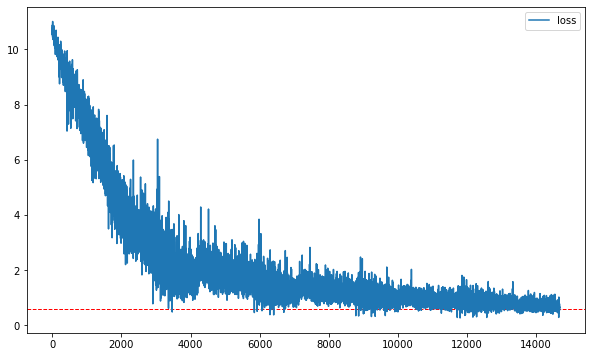

"Chain of Strength" | "Tolis Voskopoulos", "Foie Gras", "A Girl Called Eddy", "Six Cents and Natalie"
"Saint Cava" | "Samurai Champloo", "Fat Tulips", "Raul Seixas", "Saint Etienne Daho"
"Little Jimmy Scott" | "Madeleine Peyroux & William Galison", "B Bumble & The Stingers", "Kel Assouf", "Cal Tjader & Carment McRae"
"Mortem" | "J.A.M.", "London After Midnight", "I:Scintilla", "Mr. Boogie Woogie"
"Chris Brown feat. Rihanna" | "JennyAnyKind", "Blue Peter", "Rose Rovine e Amanti", "Neck"
"Dungeonesse" | "Krinjah", "Manu Gavassi", "Makeup and Vanity Set", "Vertical Church Band"
"Group X" | "Restoring Poetry in Music", "Norther", "Artento Divini", "Spheric Universe Experience"
"Dubbledge" | "Hammercult", "Breaking Pangaea", "Agent Ribbons", "Mongol Horde"
"Aghast View" | "Manny Marc, Corus 86 & DJ Reckless", "Gregg Anthe", "The Brendan Hines", "The Asteroids Galaxy Tour"
"Anbu" | "Swarms ft. Holly Prothman", "Easy M", "Choir of Kings College, Cambridge", "Winter Severity Index"
...



In [23]:
history = []
test_history = []
for e in range(epochs):
    for input_words, target_words in get_batches(train_playlists, 1024):
        inputs, targets = torch.LongTensor(input_words), torch.LongTensor(target_words)
        inputs, targets = inputs.to(device), targets.to(device)

        input_vectors = model.forward_input(inputs)
        output_vectors = model.forward_output(targets)
        noise_vectors = model.forward_noise(inputs.shape[0], 5)

        loss = criterion(input_vectors, output_vectors, noise_vectors)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        print("Epoch: {}/{}".format(e+1, epochs), loss.item())
        history.append(loss.data.cpu().numpy())

        clear_output(True)
        plt.figure(figsize=(10,6))
        plt.axhline(y=history[-1], ls='--', linewidth=1, color='r')
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()
        
        valid_examples, valid_similarities = cosine_similarity(model.in_embed, device=device)
        _, closest_idxs = valid_similarities.topk(5)

        valid_examples, closest_idxs = valid_examples.to('cpu'), closest_idxs.to('cpu')
        for ii, valid_idx in enumerate(valid_examples):
            closest_words = [id_to_author[idx.item()] for idx in closest_idxs[ii]][1:]
            print(id_to_author[valid_idx.item()] + " | " + ', '.join(closest_words))
        print("...\n")
    np.save('item2vec.npy', np.array(model.in_embed.weight.cpu().detach().numpy()))
    test_history.append(np.nanmean(np.array([np.linalg.norm(cosine_similarity(model.in_embed, sample=playlist)[1].cpu().detach().numpy()) / len(playlist) for playlist in test_playlists])))

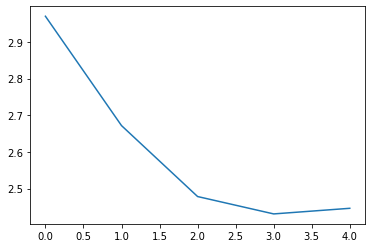

In [24]:
del train_playlists
# тестовое внутри плейлистовое косинусное расстояние
plt.plot(test_history)
# наблюдаем оверфит

In [25]:

output_notebook()

def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    if isinstance(color, str): color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: pl.show(fig)
    return fig

Loading BokehJS ...

In [26]:
embedding = umap.UMAP(n_neighbors=5).fit_transform(model.in_embed.weight.cpu().detach().numpy())

In [69]:
# Нарисуем Кино, Фрэнка Синатру и 50 cent
valid_examples, valid_similarities =cosine_similarity(model.in_embed, sample=[6671, 3373, 161], find_n = True)
_, closest_idxs = valid_similarities.topk(10)

In [70]:
closest_idxs = closest_idxs.cpu().numpy().flatten()
tokens = [id_to_author[id_] for id_ in closest_idxs]

In [71]:
tokens

['"Gruppa Kino"',
 '"Ночные Снайперы"',
 '"DDT"',
 '"In Strict Confidence"',
 '"Zемфира"',
 '"Би-2 & Brainstorm"',
 '"Пилот"',
 '"Splin"',
 '"Stare Dobre Małżeństwo"',
 '"Him & Her"',
 '"КиШ"',
 '"Rammstien"',
 '"Пилот"',
 '"Marilyn Manson & Sneaker Pimps"',
 '"Pain"',
 '"Slipknot"',
 '"Kittie"',
 '"Austrian Death Machine"',
 '"Ляпис Трубицкой & Грув"',
 '"Агата Кристи"',
 '"Frank Sinatra & Tanya Tucker"',
 '"Nat King Cole & Dean Martin"',
 '"Dean Martin With Nelson Riddle & His Orchestra"',
 '"Louis Armstrong & Ella Fitzgerald with Sy Oliver\x92s Orchestra"',
 '"Bing Crosby & Bob Hope"',
 '"Ella Fitzgerald & The Four Hits And A Miss"',
 '"Elvis Presley & Martina McBride"',
 '"Peggy Lee"',
 '"Brenda Lee"',
 '"Ray Charles & George Michael"']

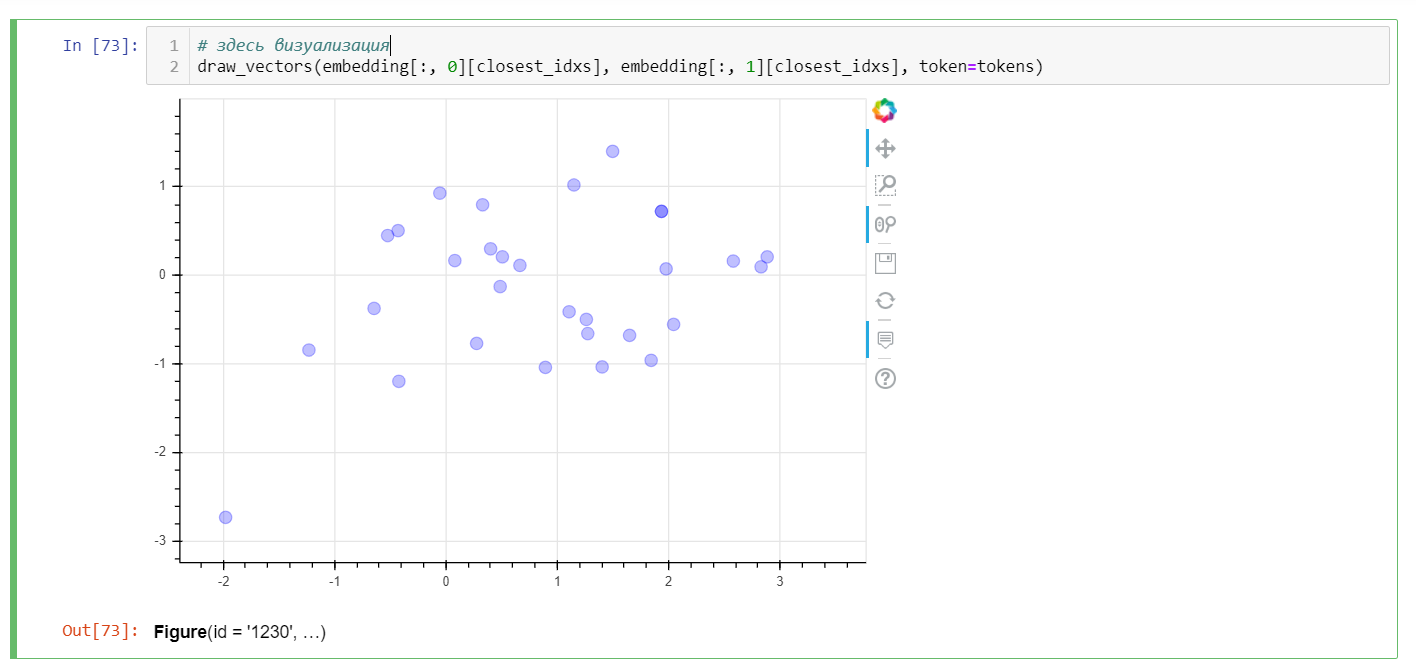

In [73]:
# здесь визуализация
draw_vectors(embedding[:, 0][closest_idxs], embedding[:, 1][closest_idxs], token=tokens)

Figure(id='1230', ...)

Мы видим, что кластеризуются исполнители плоховато, но ближайшие соседи не такие уж и плохие

Группа Кино - преимущественно русскоязыные исполнители (на размере эмбедингов 300 результат еще лучше)
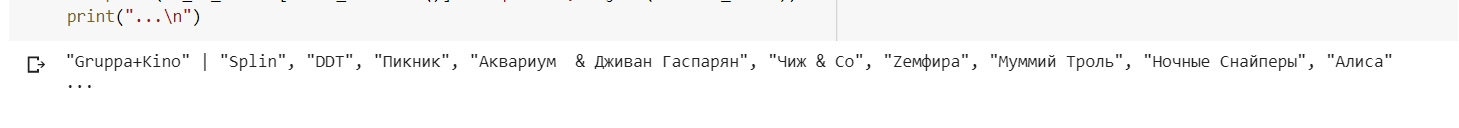

In [33]:
valid_examples, valid_similarities = cosine_similarity(model.in_embed, sample=[6671], find_n=True)
_, closest_idxs = valid_similarities.topk(10)
closest_idxs = closest_idxs.cpu().tolist()[0]
closest_words = [id_to_author[idx] for idx in closest_idxs[1:]]
print(id_to_author[6671] + " | " + ', '.join(closest_words))


"Gruppa Kino" | "Ночные Снайперы", "DDT", "In Strict Confidence", "Zемфира", "Би-2 & Brainstorm", "Пилот", "Splin", "Stare Dobre Małżeństwo", "Him & Her"


Классика зарубежного металла

In [52]:
valid_examples, valid_similarities = cosine_similarity(model.in_embed, sample=[1014], find_n=True)
_, closest_idxs = valid_similarities.topk(10)
closest_idxs = closest_idxs.cpu().tolist()[0]
closest_words = [id_to_author[idx] for idx in closest_idxs[1:]]
print(id_to_author[1014] + " | " + ', '.join(closest_words))

"Metallica, Michael Kamen & San Francisco Symphony" | "Iron Maiden & Dream Theater", "Guns 'N' Roses", "AC-DC", "Megadeath", "Deep Purple & KISS", "Pantera", "Scorpions - Moment Of Glory", "Judas Priest", "Aerosmith"


Рэп

In [55]:
valid_examples, valid_similarities = cosine_similarity(model.in_embed, sample=[588], find_n=True)
_, closest_idxs = valid_similarities.topk(10)
closest_idxs = closest_idxs.cpu().tolist()[0]
closest_words = [id_to_author[idx] for idx in closest_idxs[1:]]
print(id_to_author[588] + " | " + ', '.join(closest_words))


"50 Cent feat. Snoop Dogg & Pre" | "Jay-Z & Kanye West", "Snoop Dogg feat.The Doors", "Eminem feat. Nate Dogg", "Kanye west ft. frank ocean", "T.I.", "Friday/Dr. Dre", "Lil Wayne Feat. Drake & Rick Ross", "Drake & Coldplay", "DMX & Rakim Ft Shontelle & Aleks D"


#### Validation

In [74]:
item2vec = np.load('item2vec.npy')

In [114]:
def get_error(id_, real_vec, method, verbose=False):
    if method == 'baseline':
        
        similarities = (result_vecs[id_, :] @ result_vecs.T)/magnitudes_base
        
        nonzero = np.nonzero((similarities / magnitudes_base[id_]) < (similarities[id_]/ magnitudes_base[id_]))
        
        if len(nonzero[0]) > 0 :
            id_in_nonzero = np.argmax(similarities[nonzero])
            
            if verbose:
                print()
                print('BASELINE')
                print('Predicted - ', id_to_author[id_in_nonzero])
                print()

        
            return int(real_vec == id_in_nonzero)
        return 0
   
    else:
        similarities = (item2vec[id_, :] @ item2vec.T)/magnitudes_item
        
        nonzero = np.nonzero((similarities / magnitudes_item[id_]) < (similarities[id_]/ magnitudes_item[id_]))
        id_in_nonzero = np.argmax(similarities[nonzero])
        
        if verbose:
            print('ITEM2VEC')
            print('Predicted - ', id_to_author[id_in_nonzero])
            print()

        return int(real_vec == id_in_nonzero)

In [115]:
method_1 = []
method_2 = []

magnitudes_base = np.sqrt(np.power(result_vecs, 2).sum(axis=1))
magnitudes_item = np.sqrt(np.power(item2vec, 2).sum(axis=1))

for playlist in tqdm.tqdm_notebook(test_playlists):
    m1 = []
    m2 = []
    playlist = list(dict.fromkeys(playlist).keys())
    if len(playlist) > 1:
        for i in range(len(playlist)-1):

    #         print('Current - ', id_to_author[playlist[i]])
    #         print('Next - ', id_to_author[playlist[i+1]])
            m1.append(get_error(playlist[i], playlist[i+1], method='baseline', verbose=False))
            m2.append(get_error(playlist[i], playlist[i+1], method='i2w', verbose=False))
        
        method_1.append(sum(m1)/len(m1))
        method_2.append(sum(m2)/len(m2))

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [116]:
print('Среднее случайных предсказаний :', 1 / item2vec.shape[0])

Среднее случайных предсказаний : 7.2170900692840645e-06


In [120]:
print('Метод baseline')
print('Среднее :', np.mean(method_1))
print('Границы 95% дов. интервала :', st.t.interval(0.95, len(method_1), loc=np.mean(method_1), scale=st.sem(method_1)))

Метод baseline
Среднее : 8.82312433288572e-05
Границы 95% дов. интервала : (-2.503249972483828e-05, 0.00020149498638255268)


Среднее случайных предсказаний попадает в 95% доверительный интервал baseline

In [121]:
print('Метод item2vec')
print('Среднее :', np.mean(method_2))
print('Границы 95% дов. интервала :', st.t.interval(0.95, len(method_2), loc=np.mean(method_2), scale=st.sem(method_2)))

Метод item2vec
Среднее : 0.004886978726047396
Границы 95% дов. интервала : (0.003949691725504531, 0.0058242657265902605)


Т.к. выборки зависимы, проверить гипотезу о положительной разности средних предсказаний метода два и метода один можно с помощью одностороннего критерия Вилкоксона

H0: Разница между выборками нулевая
H1: Разница между выборками больше нуля

In [122]:
print(st.wilcoxon(np.array(method_2) - np.array(method_1)))

WilcoxonResult(statistic=717.5, pvalue=1.820358424796903e-64)


Нулевая гипотеза отвергается в пользу альтернативы на достигаемом уровне значимости 5%

#### Выводы

Полученные векторные представления с помощью item2vec подхода получились гораздо лучше "глупого" бейзлайна. 
Толковый подбор гиперпараметров сделать не удалось, т.к. когда размер векторов >200 мне не хватает памяти на моем компьютере. А Google Collabу не хватает памяти чтобы загрузить все вектора себе в память.

Из того что удалось понять - вектора длинной 300 лучше чем 200 и 150. Вектора длинной 300 переобучаются на 5ой эпохе.
Learning rate 0.003 - 0.005 для старта оптимальный.

Наверное лучшим решением такой задачи будет SVD по матрице пользователь-артист. Но в таком решении, как и в моем, существует проблема **холодных** артистов, которых еще никто не слушал. Сечас такие артисты просто выбрасываются из теста, если их не было в трейне.

Вектора SVD таких артистов можно приближать с помощью нейронки, которая на вход получала бы какую-нибудь информацию о артистах или их песнях (мел разложение например), и предсказывала бы вектор item2veca или svd-разложения.

Неиспользованные данные 'events' и 'love' можно было бы применить для разложения. А данные 'albums' и 'tags' для приблежения векторов холодных артистов
